# **Twitter Sentiment Analysis**

## **Importing Libraries**

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## **Exploratory Data Analysis**

### **Preprocessing the Dataset**

In [3]:
df = pd.read_csv("twitter_sentiment.csv")
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [16]:
df.isna().sum()

Index          0
Game           0
Sentiment      0
Review       686
dtype: int64

In [17]:
df['Review'] = df['Review'].fillna('')

In [5]:
df.columns = ['Index', 'Game', 'Sentiment', 'Review']

In [18]:
df.drop("Index", axis = 1)

,Game,Sentiment,Review
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...
75676,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75677,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75678,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75679,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [15]:
df.dtypes

Index         int64
Game         object
Sentiment    object
Review       object
dtype: object

In [84]:
# Functions to use for Feature Extraction

def char_counts(text):
    return len(text)

def word_counts(text):
    return len(text.split())

def avg_wordlength(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words) if words else 0

def stopwords_counts(text):
    words = text.split()
    return len([word for word in words if word in STOPWORDS])

def hashtag_counts(text):
    return len(re.findall(r'#\w+', text))

def mentions_counts(text):
    return len(re.findall(r'@\w+', text))

def digits_counts(text):
    return len(re.findall(r'\d', text))

def uppercase_counts(text):
    return len([char for char in text if char.isupper()])

def lowercase_counts(text):
    return len([char for char in text if char.islower()])

def remove_urls(text):
    """Remove URLs from text"""
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_retweets(text):
    """Remove 'RT' and 'via' retweet indicators"""
    return re.sub(r'\bRT\b|\bvia\b', '', text)

def remove_special_characters(text):
    """Remove special characters and punctuation"""
    return re.sub(r'[^\w\s]', '', text)

def remove_html_tags(text):
    """Remove HTML tags from text"""
    return BeautifulSoup(text, "html.parser").get_text()

def convert_to_lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

def remove_extra_whitespace(text):
    """Remove extra whitespace and newline characters"""
    return ' '.join(text.split())



In [19]:
df['char_counts'] = df['Review'].apply(char_counts)
df['word_counts'] = df['Review'].apply(word_counts)
df['avg_wordlength'] = df['Review'].apply(avg_wordlength)
df['stopwords_counts'] = df['Review'].apply(stopwords_counts)
df['hashtag_counts'] = df['Review'].apply(hashtag_counts)
df['mentions_counts'] = df['Review'].apply(mentions_counts)
df['digits_counts'] = df['Review'].apply(digits_counts)
df['uppercase_counts'] = df['Review'].apply(uppercase_counts)

In [20]:
df.head()

,Index,Game,Sentiment,Review,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51,12,3.333333,6,0,0,0,2
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,10,4.100000,5,0,0,0,0
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51,10,4.200000,5,0,0,0,0
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,12,3.833333,6,0,0,1,0
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,53,10,4.400000,5,0,0,0,0


In [21]:
df.describe()

,Index,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
count,75681.000000,75681.000000,75681.000000,75681.000000,75681.000000,75681.000000,75681.000000,75681.000000,75681.000000
mean,6432.632854,108.102932,19.075078,4.908245,5.937686,0.011482,0.241553,1.490083,7.484785
std,3740.239463,79.910718,14.481623,4.912356,5.859406,0.266253,0.761861,2.942806,11.777601
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3196.000000,46.000000,8.000000,4.043478,1.000000,0.000000,0.000000,0.000000,2.000000
50%,6423.000000,90.000000,15.000000,4.576923,4.000000,0.000000,0.000000,0.000000,4.000000
75%,9602.000000,152.000000,27.000000,5.259259,9.000000,0.000000,0.000000,2.000000,9.000000
max,13200.000000,957.000000,198.000000,396.000000,41.000000,22.000000,24.000000,80.000000,396.000000


In [51]:
df.dtypes

Index                 int64
Game                 object
Sentiment            object
Review               object
char_counts           int64
word_counts           int64
avg_wordlength      float64
stopwords_counts      int64
hashtag_counts        int64
mentions_counts       int64
digits_counts         int64
uppercase_counts      int64
dtype: object

### **Analyzing the Dataset**

In [80]:
from bs4 import BeautifulSoup

def remove_urls(text):
    """Remove URLs from text"""
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_retweets(text):
    """Remove 'RT' and 'via' retweet indicators"""
    return re.sub(r'\bRT\b|\bvia\b', '', text)

def remove_special_characters(text):
    """Remove special characters and punctuation"""
    return re.sub(r'[^\w\s]', '', text)

def remove_html_tags(text):
    """Remove HTML tags from text"""
    return BeautifulSoup(text, "html.parser").get_text()

def convert_to_lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

def remove_extra_whitespace(text):
    """Remove extra whitespace and newline characters"""
    return ' '.join(text.split())

def remove_user_mentions(text):
    """Remove user mentions"""
    return re.sub(r'@\w+', '', text)

def remove_hashtags(text):
    """Remove hashtags"""
    return re.sub(r'#\w+', '', text)

def preprocess_tweet(text):
    """Combine all preprocessing functions"""
    text = remove_urls(text)
    text = remove_retweets(text)
    text = remove_special_characters(text)
    text = remove_html_tags(text)
    text = convert_to_lowercase(text)
    text = remove_extra_whitespace(text)
    text = remove_user_mentions(text)
    text = remove_hashtags(text)
    return text

In [79]:
df.groupby('Sentiment')['Sentiment'].value_counts()

Sentiment
Irrelevant    13162
Negative      22808
Neutral       18603
Positive      21108
Name: count, dtype: int64

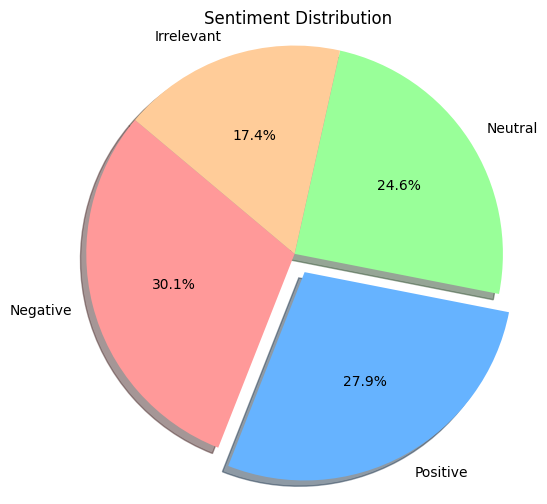

In [26]:
sentiment_counts = df['Sentiment'].value_counts()

# Labels and sizes for the pie chart
labels = sentiment_counts.index
sizes = sentiment_counts.values

# Colors for each section of the pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

# Explode the largest section for emphasis
explode = (0, 0.1, 0, 0)

plt.figure(figsize=(6, 6))

# Create the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

# Title
plt.title('Sentiment Distribution')

# Display the chart
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [28]:
df.groupby('Sentiment')['Game'].value_counts()

Sentiment   Game                             
Irrelevant  Battlefield                          930
            PlayerUnknownsBattlegrounds(PUBG)    921
            Fortnite                             855
            GrandTheftAuto(GTA)                  771
            Xbox(Xseries)                        762
                                                ... 
Positive    MaddenNFL                            404
            Google                               363
            Amazon                               319
            johnson&johnson                      274
            Facebook                             177
Name: count, Length: 128, dtype: int64

In [34]:
aggregated_df = df.groupby(['Game', 'Sentiment']).size().reset_index(name='Count')
aggregated_df.head()

,Game,Sentiment,Count
0,Amazon,Irrelevant,195
1,Amazon,Negative,582
2,Amazon,Neutral,1254
3,Amazon,Positive,319
4,ApexLegends,Irrelevant,195


In [36]:
pivot_df = aggregated_df.pivot(index='Game', columns='Sentiment', values='Count').fillna(0)
pivot_df.head()

Sentiment,Irrelevant,Negative,Neutral,Positive
Game,,,,
Amazon,195,582,1254,319
ApexLegends,195,606,959,652
AssassinsCreed,265,382,160,1470
Battlefield,930,481,364,597
Borderlands,242,431,612,1033


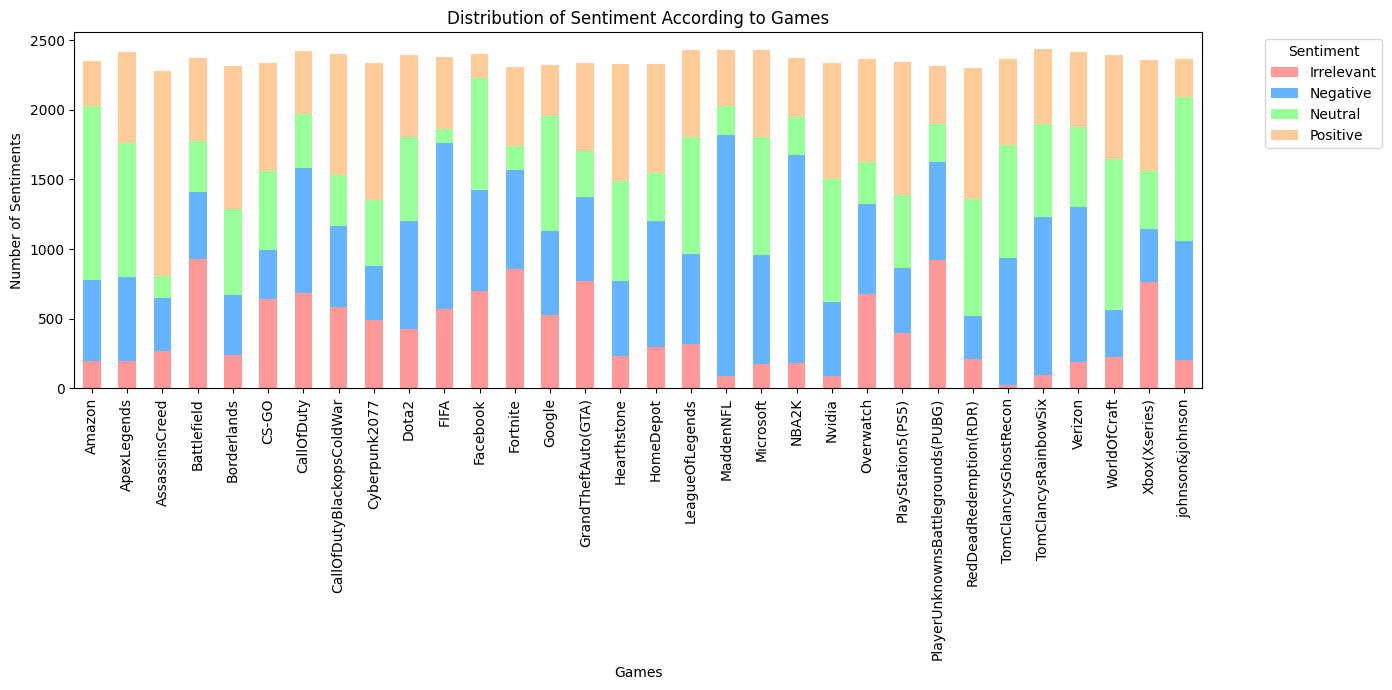

In [37]:
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 7), color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])

# Add title and labels
plt.title('Distribution of Sentiment According to Games')
plt.xlabel('Games')
plt.ylabel('Number of Sentiments')

# Display the legend and plot
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

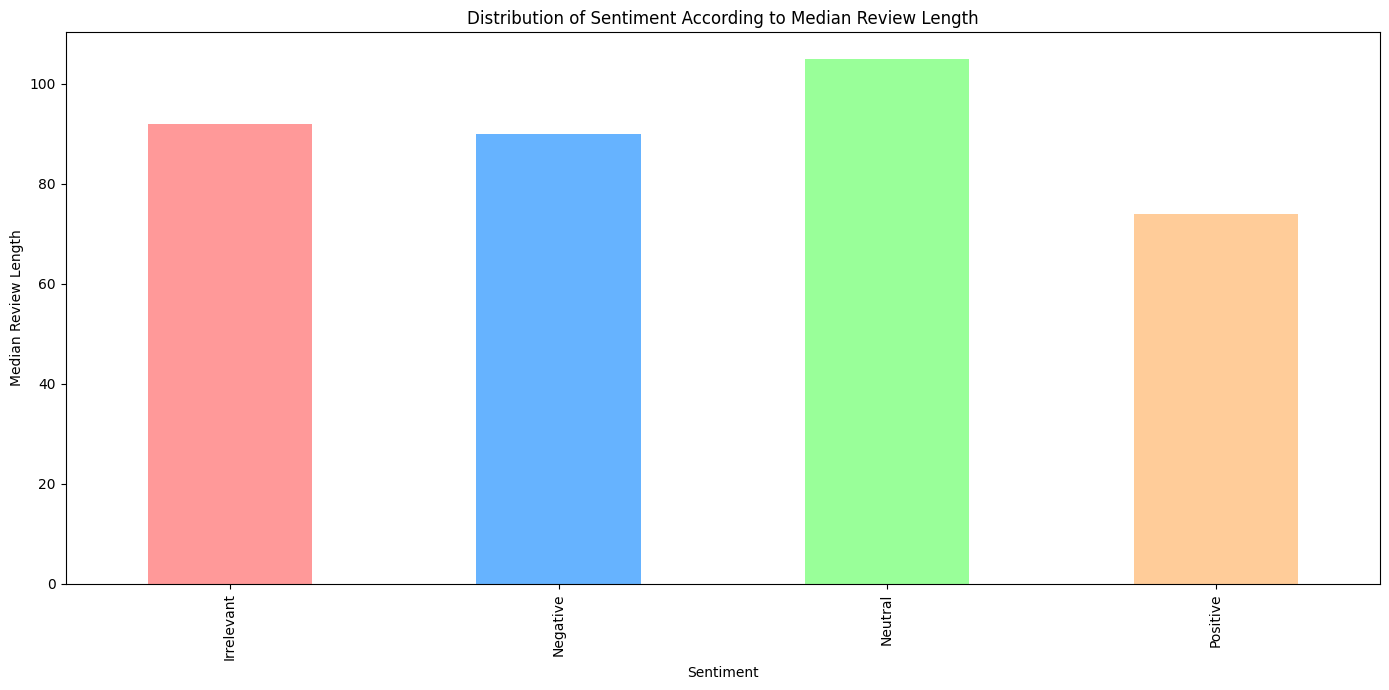

In [47]:
df.groupby('Sentiment')['char_counts'].median().plot(kind='bar',figsize=(14, 7), color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])

# Add title and labels
plt.title('Distribution of Sentiment According to Median Review Length')
plt.xlabel('Sentiment')
plt.ylabel('Median Review Length')

# Display the legend and plot

plt.tight_layout()
plt.show()

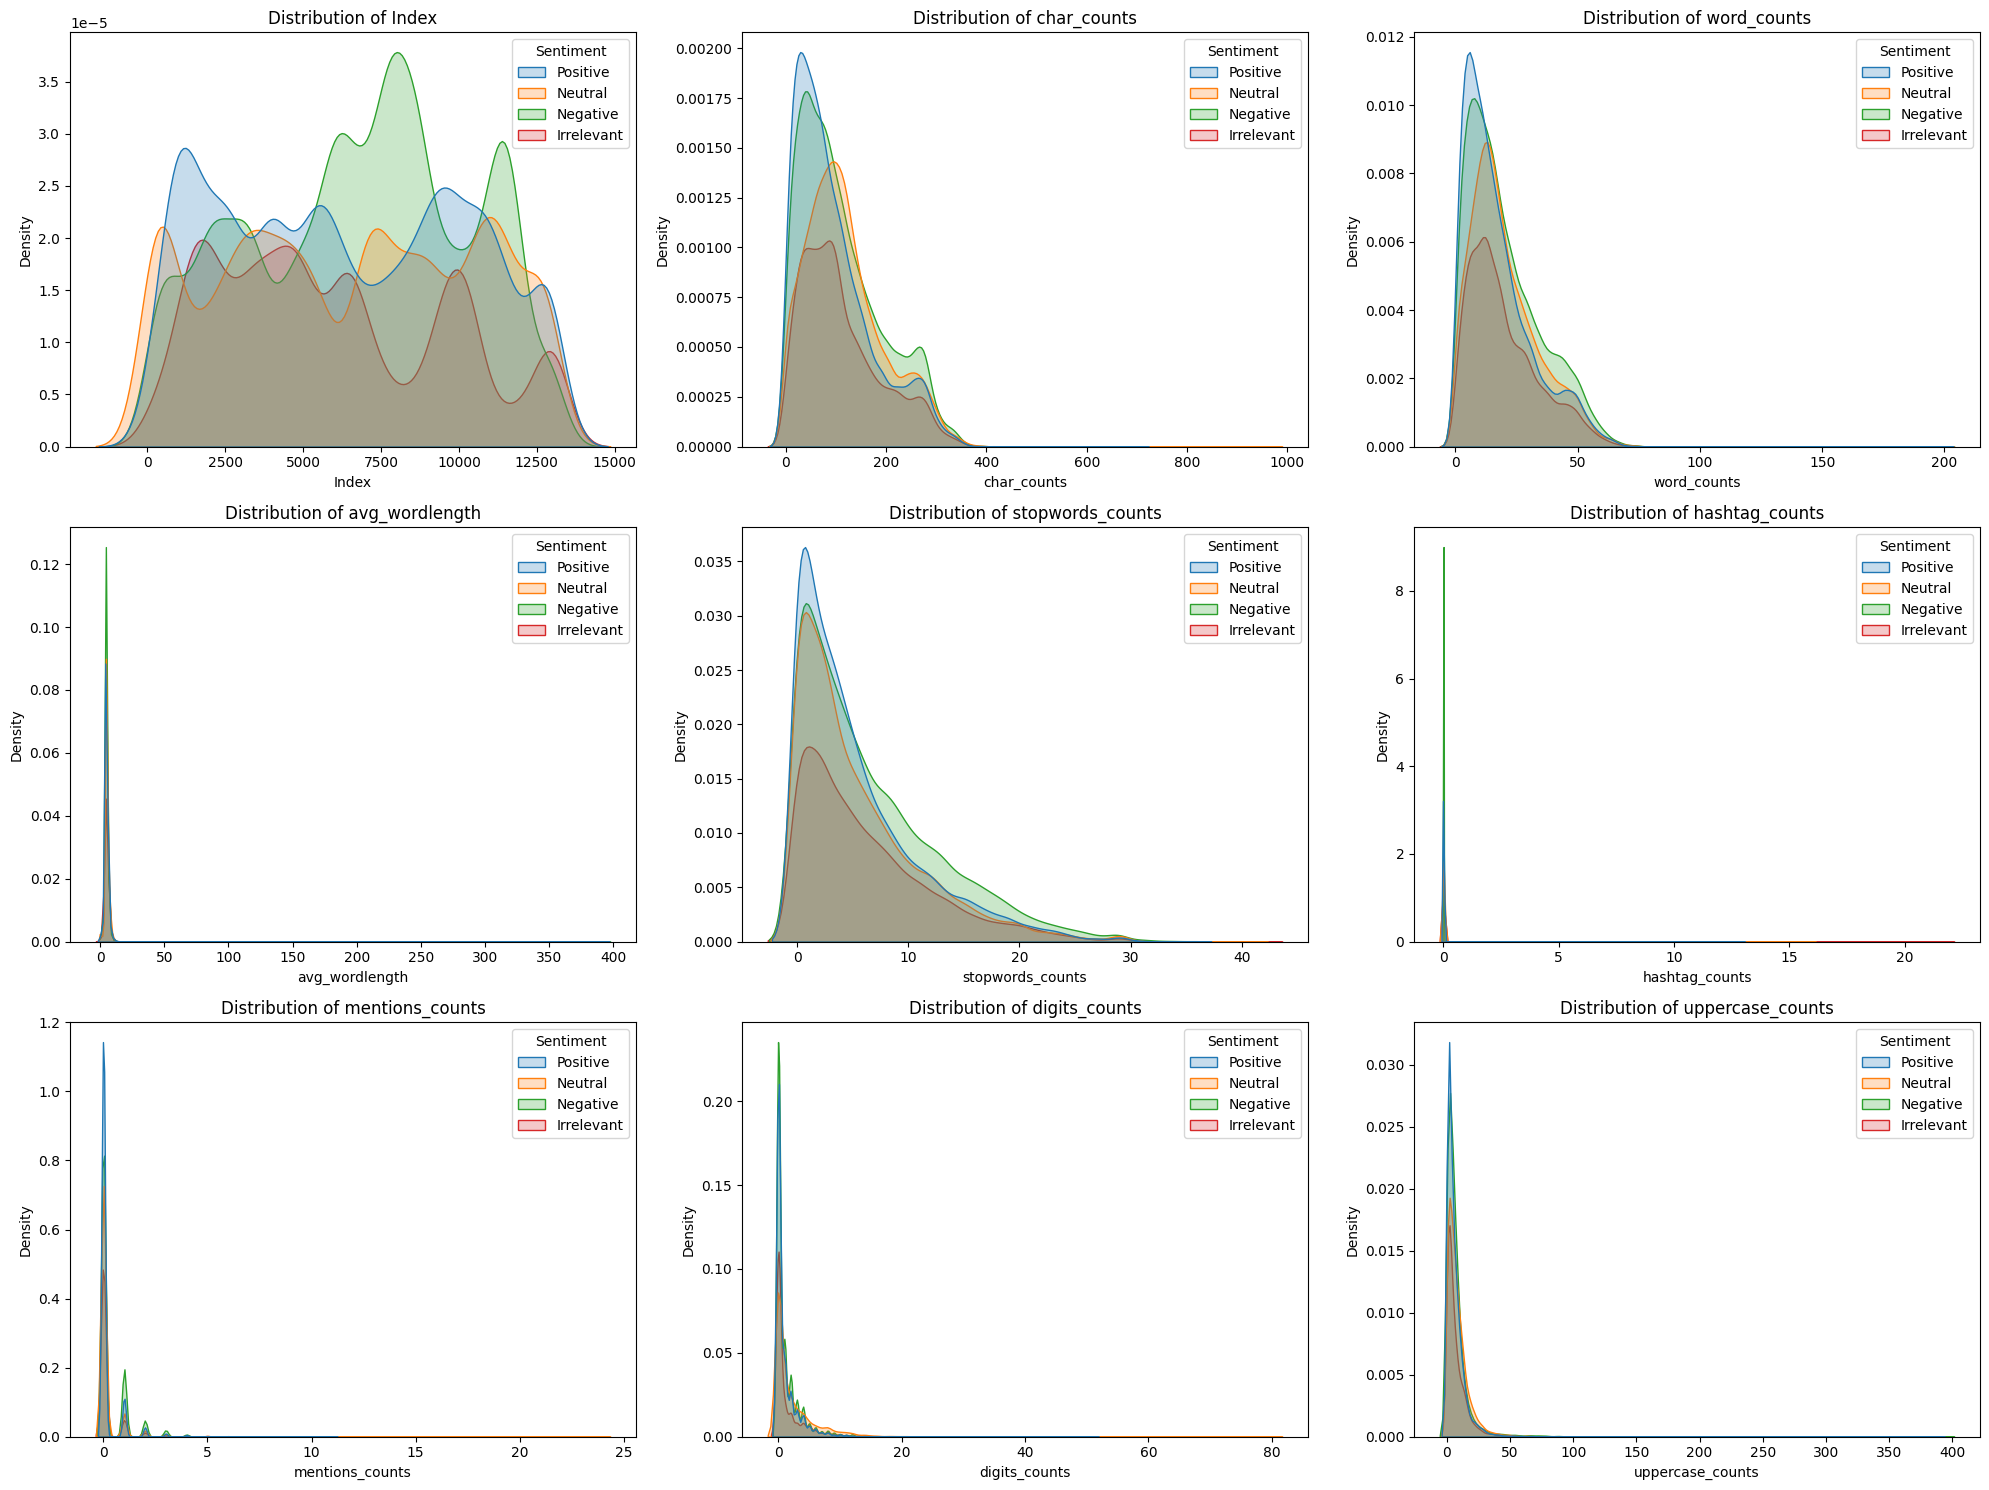

In [77]:
num_cols = df.select_dtypes(include='number').columns

# Calculate the number of rows and columns for subplots
n_cols = len(num_cols)
n_rows = (n_cols + 3) // 4  # Create enough rows to fit all plots

# Create subplots
plt.figure(figsize=(20, 5 * n_rows))  # Adjust height based on the number of rows

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, 3, i + 1)
    sns.kdeplot(data=df, x=col, hue='Sentiment', fill=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

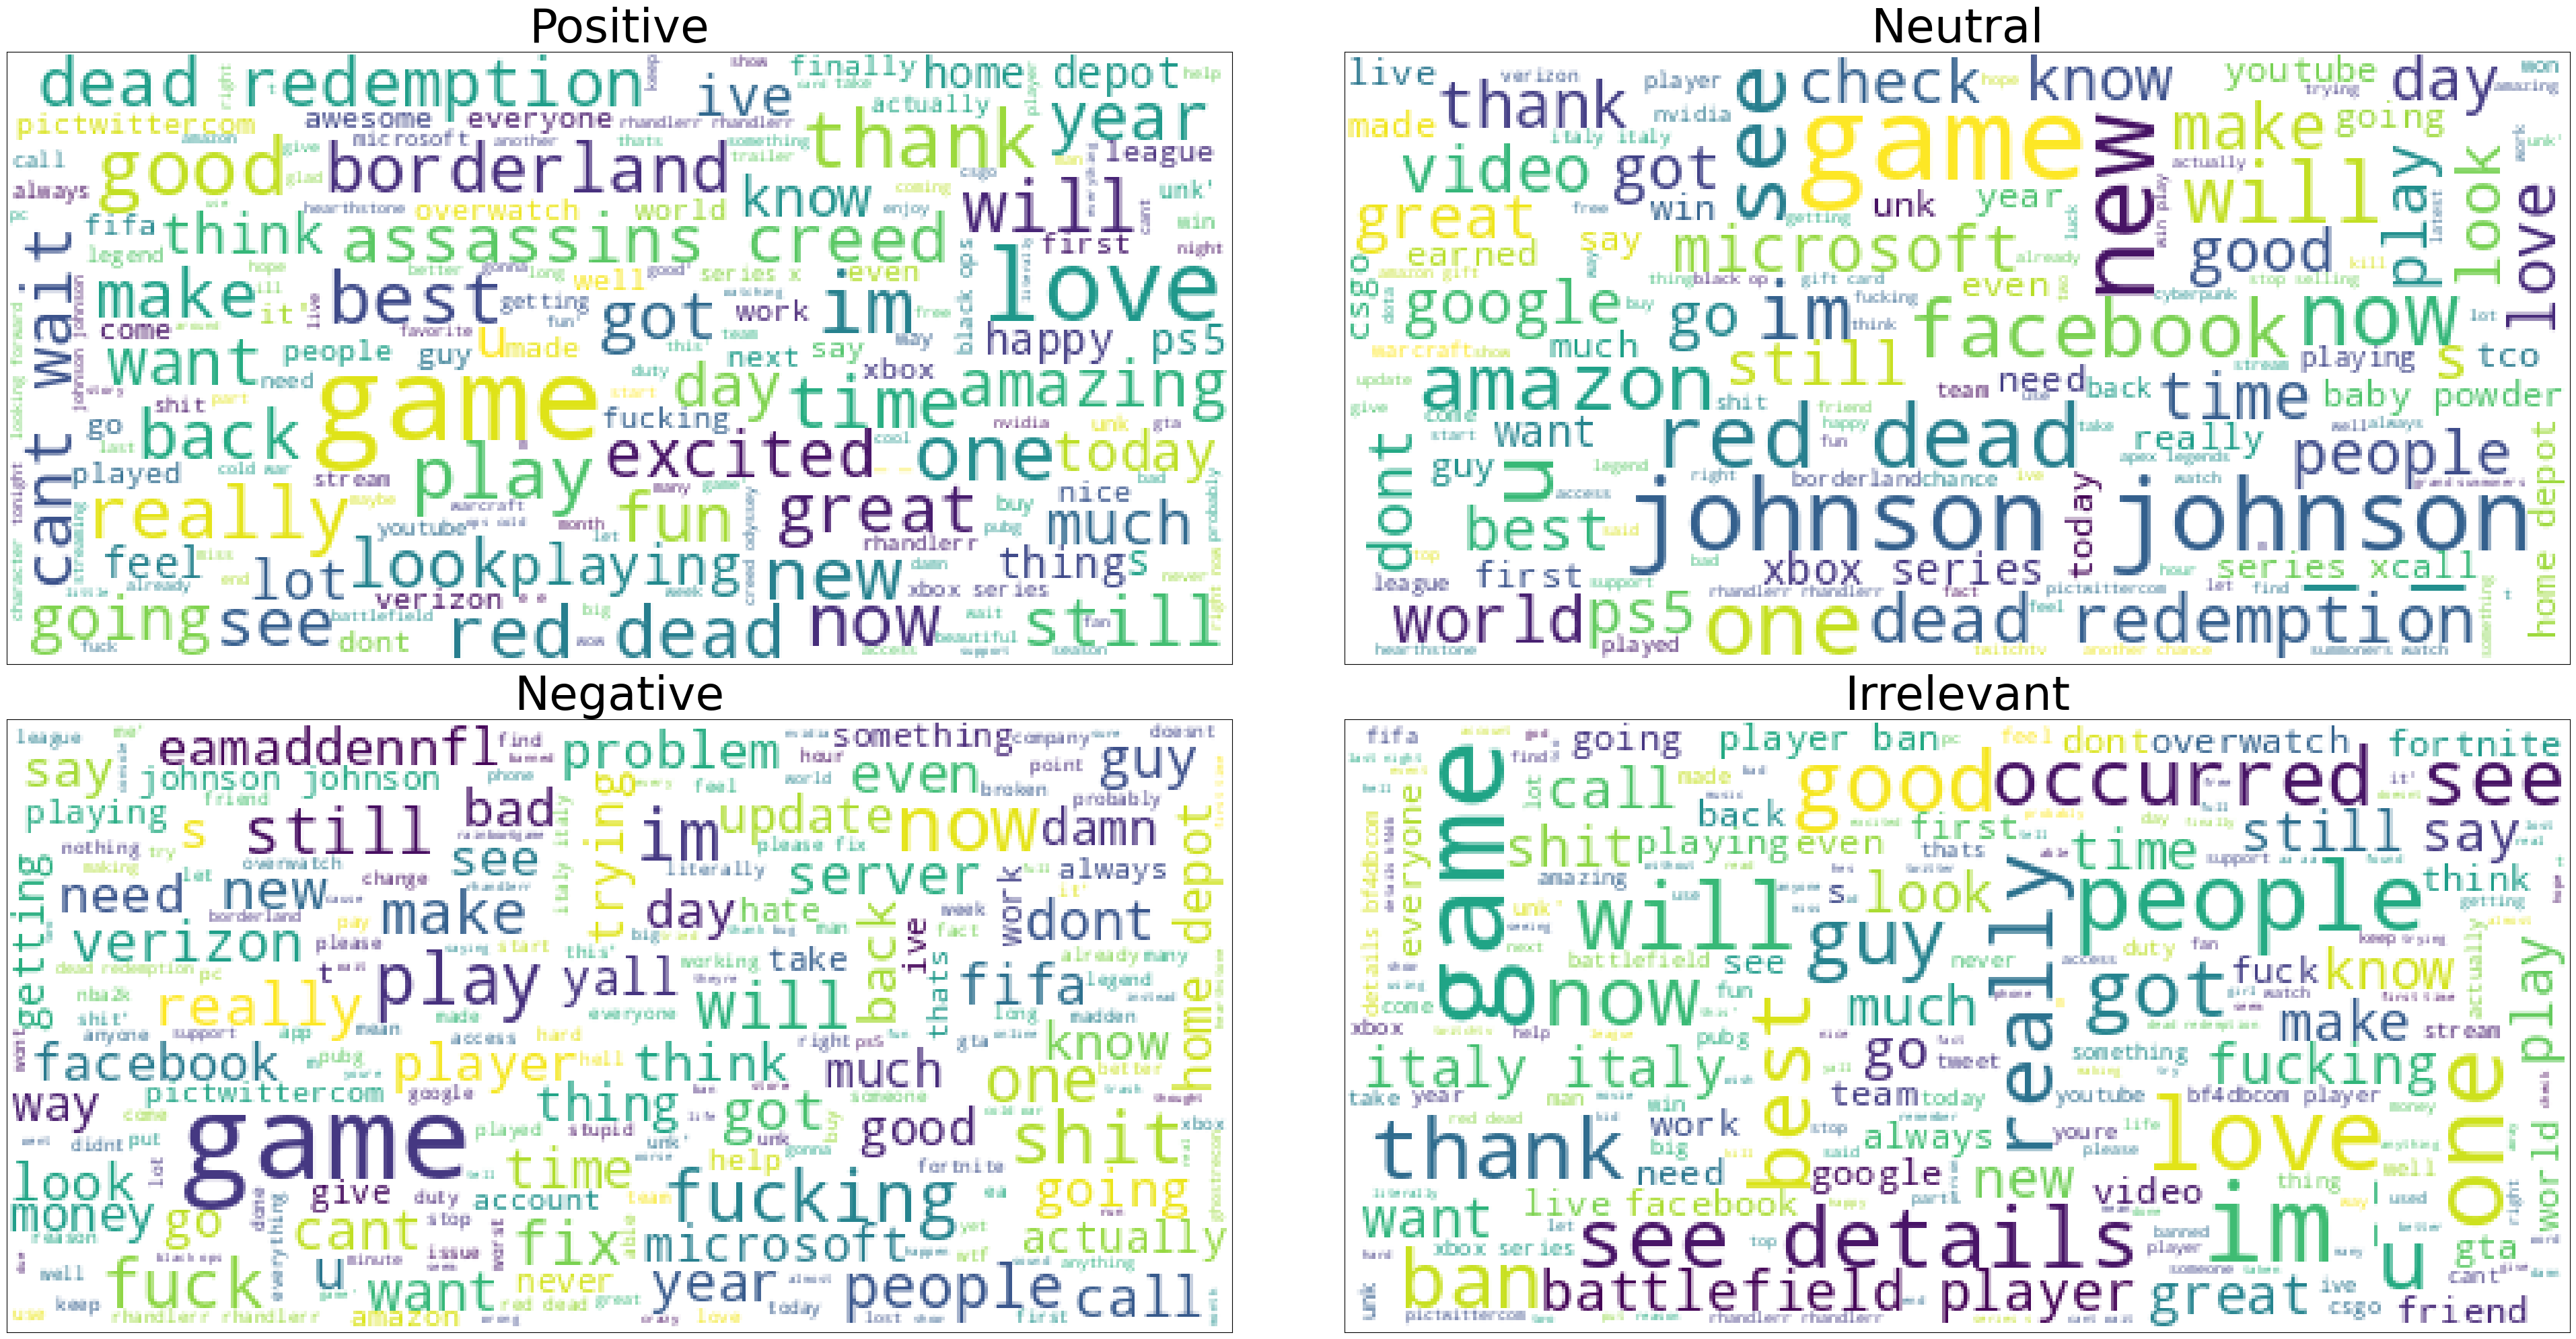

In [83]:
# plot 2x2 grid word cloud for each sentiment
plt.figure(figsize=(40,20))

for index, col in enumerate(df['Sentiment'].unique()):
    plt.subplot(2,2, index+1)
    # print(col)
    df1 = df[df['Sentiment']==col]
    data = [word for word in df1['Review'].apply(preprocess_tweet) if word not in STOPWORDS]
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=700, max_font_size=40).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=50)

plt.tight_layout()
plt.show()


## **Model Implementation**

In [87]:
def preprocess_review(text):
    """Apply all preprocessing functions to a review"""
    text = remove_urls(text)
    text = remove_retweets(text)
    text = remove_special_characters(text)
    text = remove_html_tags(text)
    text = convert_to_lowercase(text)
    text = remove_extra_whitespace(text)
    return text

In [88]:
df['Cleaned_Reviews'] = df['Review'].apply(preprocess_review)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_Reviews'], df['Sentiment'], test_size=0.2, random_state=42)

In [107]:
stopwords_list = list(stopwords)

clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords_list)),
    ('clf', RandomForestClassifier(n_jobs=-1, class_weight='balanced'))
])

In [108]:
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [99]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9011032569201295


In [100]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

  Irrelevant       0.96      0.84      0.90      2615
    Negative       0.92      0.92      0.92      4552
     Neutral       0.84      0.92      0.88      3741
    Positive       0.91      0.90      0.90      4229

    accuracy                           0.90     15137
   macro avg       0.91      0.90      0.90     15137
weighted avg       0.90      0.90      0.90     15137



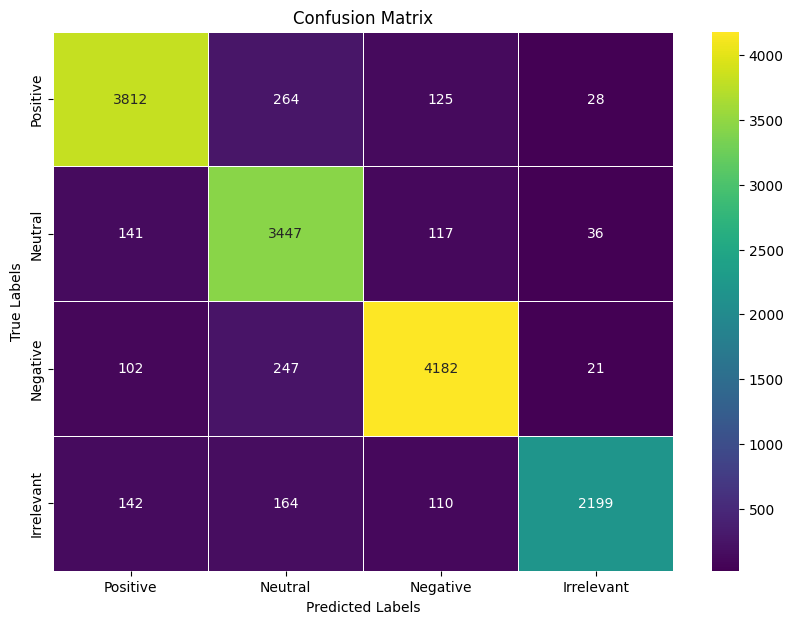

In [106]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=labels)

# Get unique labels from the DataFrame
labels = df['Sentiment'].unique()
# Create a DataFrame for better visualization with labels
cm_df = pd.DataFrame(cm, index=labels, columns=labels)


plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='viridis', linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [114]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.88950367 0.8844661  0.89024692 0.88900818 0.88610836]
Mean cross-validation score: 0.8878666464341913


In [111]:
clf.predict(["I am really glad to see you"])

array(['Positive'], dtype=object)

In [112]:
import pickle

pickle.dump(clf, open("twitter_sentiment.pkl", "wb"))